<a href="https://colab.research.google.com/github/fcoelhomrc/MachineLearning/blob/main/APC_Exercises/TP_MachineLearning_16_11_2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Density estimation

In the domain of generative classifiers, we can define non-parametric models. 

They are based on density estimation, where the problem is framed as:

$x$ is a continuous variable with a unknown density function $p(x)$. Given a sample $\{x_1, \dots, x_n\}$ of i.i.d. observations, we wish to estimate $p(x)$ **without imposing constraints**.

## Parzen window / Kernel density estimation

We can select a kernel function $K(x, x_i)$, and estimate $p(x)$ as:

$$
p(x) \approx \frac{1}{n}\sum_{i=1}^{n}K(x, x_i)
$$

The kernel function is usually written as
$$
K(a, b) = \frac{1}{h}g\left(\frac{a - b}{h}\right)
$$
where $g$ is a single-variable, real-valued function.  It needs to be non-negative,  i.e $K(a, b) \ge 0, \forall a,b$. 

$K$ must represent some notion of **similarity**.

The constant $h$ is a hyper-parameter, whose meaning is clearer once we consider some usual choices of $K$.

The factor $\frac{1}{h}$ is a normalization factor, which is required to counter the rescaling of $g$'s area due to $h$ choice.

1. Gaussian kernel

This is the most common choice.

$$
g \sim \mathcal{N}(0, 1)
$$

In this case, $h$ controls the width of the Gaussian curve.

2. Rectangular kernel

This is the simplest kernel.

$$
g(z) = \begin{cases}
1, \, -\frac{1}{2} \le z \le \frac{1}{2} \\
0, \, \text{else}
\end{cases}
$$

3. Triangular kernel

This can be thought as a linerarized version of the Gaussian kernel.

$$
g(z) = \begin{cases}
1 - |z|, \, -1 \le z \le 1 \\
0, \, \text{else}
\end{cases}
$$

### Optimizing $h$

A strategy to finding the best value for $h$ is to separate the available data into training and validation sets.

We estimate $p(x)$ with the training data, and then use the result to compute $p(x)$ for observing the validation data.

Since we assume the data is i.i.d., this is simply $\prod_{i=1}^{n_{\text{val}}} p(x_i)$.

However, since density values are often very small, it is likely that this product will lead to numerical stabilities since it will become exponentially small (with $n_{\text{val}}$). Instead, it is much more stable to compute everything in logarithmic scale, i.e. $\sum_{i=1}^{n_{val}}\log p(x+i)$

Scores: [2.4650191616901548e-05, 7.796169426915257e-05, 6.362137296763871e-05, 2.9675241942193662e-05]


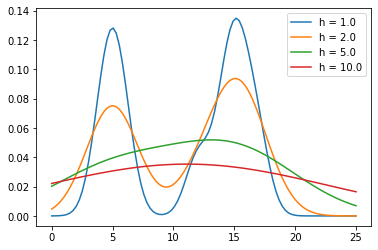

Scores: [0.0, 0.0, 0.008639999999999998, 0.07068599999999998]


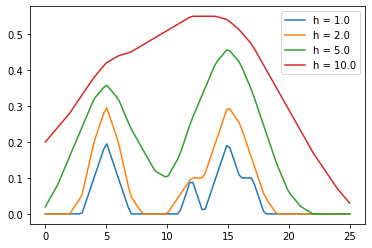

In [21]:
# Define the kernels
def gaussian_kernel(x, xi, h):
    z = (x - xi)/h
    return norm.pdf(z) / h

def triangular_kernel(x, xi, h):
    z = (x - xi)/h
    return 0 if np.abs(z) > 1 else 1 - np.abs(z)

class KDE:
    def __init__(self, kernel_fn, h):
        self.kernel_fn = kernel_fn
        self.h = h
    
    def fit(self, X):
        n = X.shape[0]
        self.density_fn = lambda x: sum([self.kernel_fn(x, xi, h=self.h) for xi in X]) / n

    def predict(self, X):
        return np.array([self.density_fn(xi) for xi in X])

Xtrain = np.array([4, 5, 5, 6, 12, 14, 15, 15, 16, 17])
Xtest = np.array([3, 10, 5])

X = np.linspace(0, 25, 100)
scores = []
for h in [1.0, 2.0, 5.0, 10.0]:    
    gauss_kde = KDE(gaussian_kernel, h)
    gauss_kde.fit(Xtrain)
    preds = gauss_kde.predict(X)
    score = np.prod(gauss_kde.predict(Xtest))
    scores.append(score)
    plt.plot(X, preds, label=f"h = {h}")
print(f"Scores: {scores}")
plt.legend()
plt.show()

X = np.linspace(0, 25, 100)
scores = []
for h in [1.0, 2.0, 5.0, 10.0]:    
    tri_kde = KDE(triangular_kernel, h)
    tri_kde.fit(Xtrain)
    preds = tri_kde.predict(X)
    score = np.prod(tri_kde.predict(Xtest))
    scores.append(score)
    plt.plot(X, preds, label=f"h = {h}")
print(f"Scores: {scores}")
plt.legend()
plt.show()

# Logistic regression

This is an example of discriminative classifier. Even though it is called regression, it is a **binary classification algorithm** (in its base form).

It's mathematically defined below:
$$
\begin{align}
y &\in \{0, 1\} \\
p(y=1|x) &= \sigma(x^T \theta) = \frac{1}{1 + \exp{-x^t \theta}}
\end{align}
$$

It is easy to see that this satisfies $p(y=0|x) = 1 - p(y=1|x) = \sigma (-x^T \theta)$

See more theory on my notes.

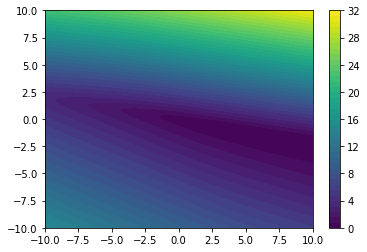

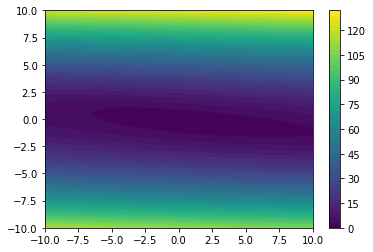

In [34]:
# Data
X = np.array([0.5, 1.8, 3.6, 4.5, 5.1, 6.5]).reshape(-1, 1)
y = np.array([1, 1, 1, 0, 0, 0])

# Utils
def log_sigmoid(z):
    return -np.log(1 + np.exp(-z))

# Parameter grid
theta0 = np.linspace(-10, 10, 1000)
theta1 = np.linspace(-10, 10, 1000)
theta0, theta1 = np.meshgrid(theta0, theta1)
theta0 = theta0.reshape(-1)
theta1 = theta1.reshape(-1)

# Compute loss
z = theta0.reshape(1, -1) + theta1.reshape(1, -1)*X # shape (num_examples, num_grid_points)
loss = -np.mean(y.reshape(-1, 1) * log_sigmoid(z) + (1 - y.reshape(-1, 1)) * log_sigmoid(1 - z), axis=0)
# Add regularisation
k = 1.0
loss_reg = loss + k * theta1**2

# Plotting
theta0 = theta0.reshape(1000, 1000)
theta1 = theta1.reshape(1000, 1000)
loss = loss.reshape(1000, 1000)
loss_reg = loss_reg.reshape(1000, 1000)

surf = plt.contourf(theta0, theta1, loss,
                    levels=50, antialiased=False)
plt.colorbar()
plt.show()


surf = plt.contourf(theta0, theta1, loss_reg,
                    levels=50, antialiased=False)
plt.colorbar()
plt.show()